To link the drive to google colab


In [ ]:

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Importing important required libraries

In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


Loading the dataset from the drive

In [ ]:
#Directories for training and testing data
train_dir = "/content/drive/MyDrive/MRI Image/Training/"
test_dir = "/content/drive/MyDrive/MRI Image/Testing/"

#load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

train_paths

#load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

test_paths


['/content/drive/MyDrive/MRI Image/Testing/notumor/Te-no_0155.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-me_0075.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-me_0198.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-me_0083.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/notumor/Te-no_0037.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-me_0241.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-me_0147.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/notumor/Te-no_0207.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/notumor/Te-no_0371.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-me_0049.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/pituitary/Te-pi_0021.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/pituitary/Te-pi_0077.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/pituitary/Te-pi_0166.jpg',
 '/content/drive/MyDrive/MRI Image/Testing/notumor/Te-no_0107.jpg',
 '/content/drive/MyDrive

Data Visualization


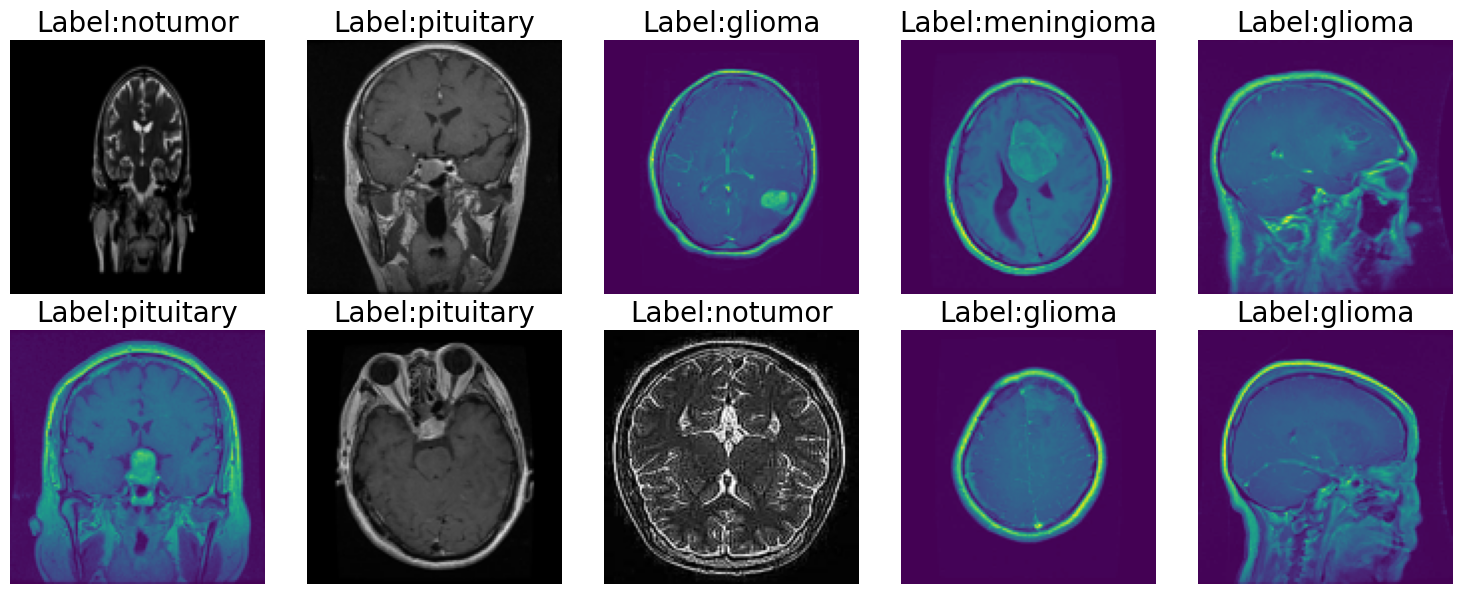

In [ ]:
import random
import matplotlib.pyplot as plt

#select random indices for 10 images
random_indices = random.sample(range(len(train_paths)),10)
random_indices

#create a figure to display images in rows
fig, axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.ravel()

#loop through the random indices and display images
for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128,128))

  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f"Label:{train_labels[idx]}" , fontsize = 20)

plt.tight_layout()
plt.show()

Image Preprocessing (Helper Functions)

In [ ]:
#Image (Augmentation Function)
def augment_image(image):
    image = image.resize((128,128))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image).astype(np.float32) / 255.0  # normalize
    return image

#Load images and apply augmentation function
def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
    img = augment_image(img)
    images.append(img)
  return np.array(images)

#label to integer, encoder function
# Build a global label-to-index map once
label_map = {label: idx for idx, label in enumerate(os.listdir(train_dir))}

def encoder_label(labels):
  return [label_map[label] for label in labels]


#data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            batch_images = open_images(batch_paths)
            batch_labels = np.array(encoder_label(batch_labels), dtype=np.int32)

            yield np.array(batch_images, dtype=np.float32), batch_labels





Model VGG16 (Tranfer learning CNN model), other includes VGG19, ResNet50

In [ ]:
#Model Archtecture

IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top = False, weights = "imagenet")

#Freeze all layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

#Unfreeze 2,3,4 last layer of the model
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#Build Model
model= Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model) #VGG16
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128,activation="relu")) #Dense Layer
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)), activation = "softmax")) #output layer

#compile the model
model.compile (optimizer = Adam(learning_rate=0.0001), loss = "sparse_categorical_crossentropy", metrics = ["sparse_categorical_accuracy"]) # in case of binary categorical_crossentropy

#parameters
batch_size = 20
steps = int(len(train_paths)/(batch_size))
epochs = 5

#train the model
history = model.fit(datagen(train_paths, train_labels, batch_size= batch_size, epochs = epochs),
                    epochs = epochs, steps_per_epoch = steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.7478
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - loss: 0.2468 - sparse_categorical_accuracy: 0.9087
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - loss: 0.1727 - sparse_categorical_accuracy: 0.9400
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9479
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9672


Visualize loss and accuracy


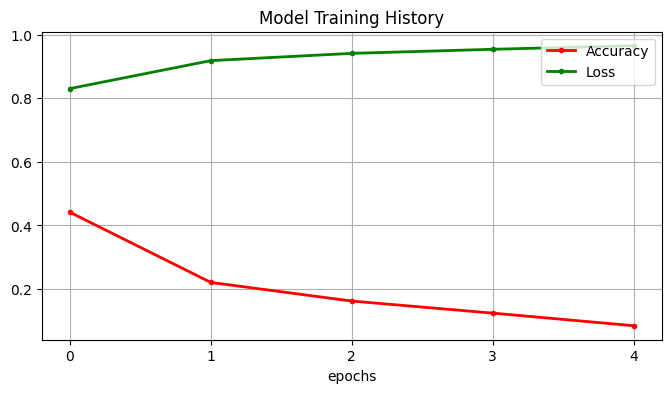

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['loss'],".r-",linewidth = 2)
plt.plot(history.history['sparse_categorical_accuracy'], ".g-", linewidth = 2)
plt.title("Model Training History")
plt.xlabel("epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(["Accuracy","Loss"], loc = "upper right", bbox_to_anchor =(1,1))
plt.show()

Model Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

test_images = open_images(test_paths)
test_label_encoded = encoder_label(test_labels)

test_predications = model.predict(test_images)

print("Classification Report")
print(classification_report(test_label_encoded, np.argmax(test_predications, axis= 1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       300
           1       0.97      1.00      0.99       405
           2       0.99      0.89      0.94       300
           3       0.92      0.90      0.91       306

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



Model Confusion Plot

confusion Matrix:
[[299   0   0   1]
 [  0 405   0   0]
 [  4   5 268  23]
 [ 21   7   4 274]]


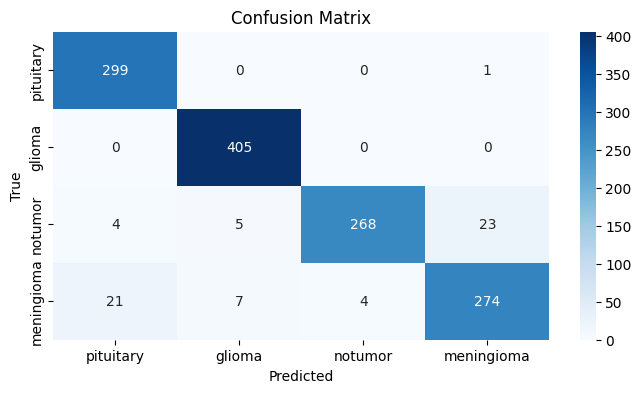

In [ ]:
conf_matrix = confusion_matrix(test_label_encoded,np.argmax(test_predications, axis = 1))
print("confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8,4))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Save and Load Model

In [ ]:
model.save("model.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model.h5")

MRI Tumor Detection System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = list(label_map.keys())


def detect_and_display(image_path, model):
  try:
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis =0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions,axis = 1)[0]

    if class_labels[predicted_class_index] == "notumor":
      result = "No tumor detected"
    else:
      result = f"tumor: {class_labels[predicted_class_index]}"

    plt.imshow(load_img(img_path))
    plt.axis("off")
    plt.title(f"{result} (Confidence:) {confidence*100:.2f}%")
    plt.show()

  except Exception as e:
    print("Error processing the image",str(e))




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


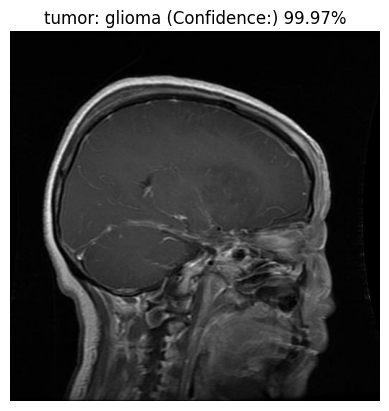

In [ ]:
#example useage
image_path = "/content/drive/MyDrive/MRI Image/Testing/glioma/Te-gl_0017.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


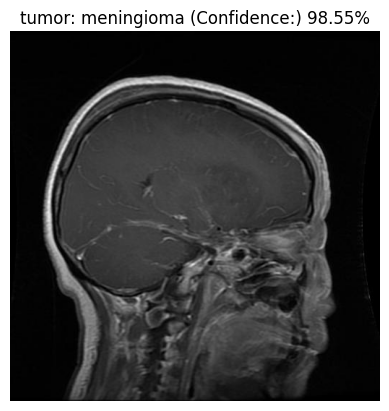

In [ ]:
#example useage
image_path = "/content/drive/MyDrive/MRI Image/Testing/meningioma/Te-meTr_0000.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


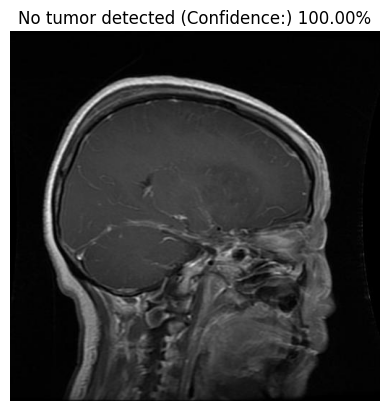

In [ ]:
#example useage
image_path = "/content/drive/MyDrive/MRI Image/Testing/notumor/Te-noTr_0001.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


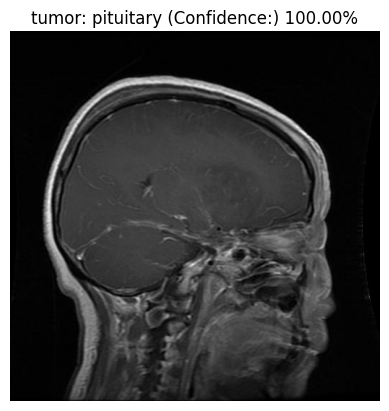

In [ ]:
#example useage
image_path = "/content/drive/MyDrive/MRI Image/Testing/pituitary/Te-piTr_0000.jpg"
detect_and_display(image_path,model)